In [39]:
# Pathway stats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [40]:
KEGG_pathway_df = pd.read_csv("KEGG_human_pathways_compounds.csv", dtype=str, index_col=0)
Reactome_pathway_df = pd.read_csv("Reactome_pathway_set.csv", dtype=str, index_col=0)
Reactome_human_pathways = Reactome_pathway_df[Reactome_pathway_df.index.str.contains("HSA")]

def process_paths(pathway_df):
    KEGG_pathways = pathway_df.dropna(axis=0, how='all', subset=pathway_df.columns.tolist()[1:])
    pathways = KEGG_pathways.index.tolist()
    pathway_names = KEGG_pathways["Pathway_name"].tolist()
    pathway_dict = {}

    for pathway in pathways:
        # perform ORA for each pathway
        pathway_compounds = KEGG_pathways.loc[pathway, :].tolist()
        pathway_compounds = [str(i) for i in pathway_compounds if str(i) != "nan"]
        cpds = pathway_compounds[1:]
        if len(cpds) > 2:
            pathway_dict[pathway] = cpds
    return pathway_dict

KEGG_pathway_dict = process_paths(KEGG_pathway_df)
Reactome_pathway_dict = process_paths(Reactome_human_pathways)

In [41]:
print(len(KEGG_pathway_dict))
print(len(Reactome_pathway_dict))

261
1171


20.0
6.0


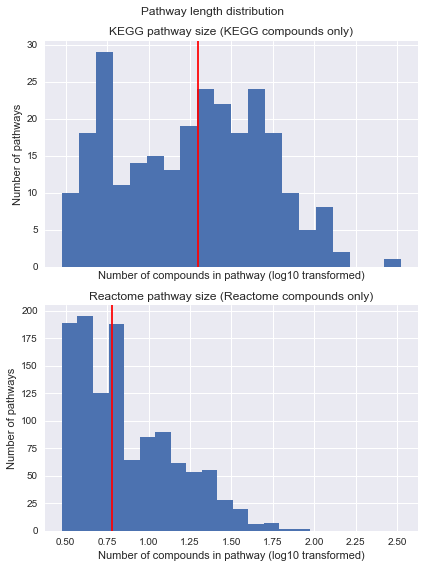

In [42]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(6,8))

pathway_length_KEGG = [len(v) for k, v in KEGG_pathway_dict.items()]
print(np.median(pathway_length_KEGG))
plt.style.use("seaborn")
plt.suptitle("Pathway length distribution")
ax1.hist(np.log10(pathway_length_KEGG), bins=20)
ax1.axvline(np.log10(np.median(pathway_length_KEGG)), c="r")
ax1.set_title("KEGG pathway size (KEGG compounds only)")
ax1.set_ylabel("Number of pathways")
ax1.set_xlabel("Number of compounds in pathway (log10 transformed)")

pathway_length_Reactome = [len(v) for k, v in Reactome_pathway_dict.items()]
print(np.median(pathway_length_Reactome))
ax2.hist(np.log10(pathway_length_Reactome), bins=16)
ax2.axvline(np.log10(np.median(pathway_length_Reactome)), c="r")
ax2.set_title("Reactome pathway size (Reactome compounds only)")
ax2.set_ylabel("Number of pathways")
ax2.set_xlabel("Number of compounds in pathway (log10 transformed)")
plt.savefig("../Figures/pathway_size_comparison.png", dpi=300)
plt.tight_layout()

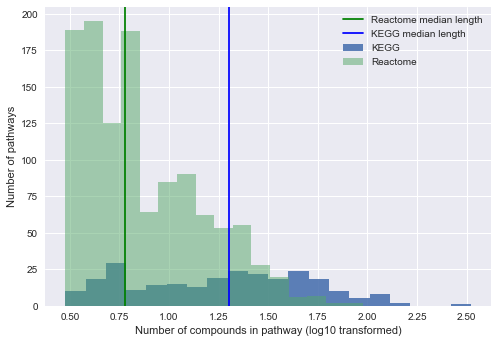

In [52]:
# Overlay hists
pathway_length_KEGG = [len(v) for k, v in KEGG_pathway_dict.items()]
pathway_length_Reactome = [len(v) for k, v in Reactome_pathway_dict.items()]
plt.hist(np.log10(pathway_length_KEGG), bins=20, alpha=0.9, label="KEGG")
plt.axvline(np.log10(np.median(pathway_length_Reactome)), c="green", label="Reactome median length")
plt.hist(np.log10(pathway_length_Reactome), bins=16, alpha=0.5, label="Reactome")
plt.axvline(np.log10(np.median(pathway_length_KEGG)), c="blue", label="KEGG median length")
plt.ylabel("Number of pathways")
plt.xlabel("Number of compounds in pathway (log10 transformed)")

plt.legend()
plt.savefig("../Figures/pathway_length_disctribution.png", dpi=300)
plt.show()

In [44]:
# Pathway overlap
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

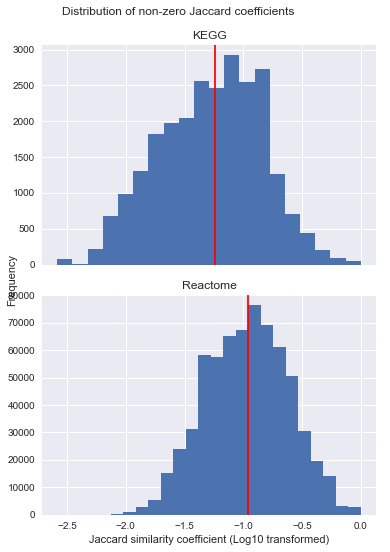

In [64]:
all_pathways_KEGG = [k for k, v in KEGG_pathway_dict.items()]
all_pathways_reactome = [k for k, v in Reactome_pathway_dict.items()]
jaccard_similarity_list_KEGG = []
jaccard_similarity_list_reactome = []
for pathway_pair in itertools.permutations(all_pathways_KEGG,2):
    jaccard_similarity_list_KEGG.append(jaccard_similarity(KEGG_pathway_dict[pathway_pair[0]], KEGG_pathway_dict[pathway_pair[1]]))
for pathway_pair in itertools.permutations(all_pathways_reactome,2):
    jaccard_similarity_list_reactome.append(jaccard_similarity(Reactome_pathway_dict[pathway_pair[0]], Reactome_pathway_dict[pathway_pair[1]]))

jaccard_non_zero_kegg = [i for i in jaccard_similarity_list_KEGG if i != 0]
jaccard_non_zero_reactome = [i for i in jaccard_similarity_list_reactome if i != 0]

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(6,8))

ax1.hist(np.log10(jaccard_non_zero_kegg), bins=20)
ax1.set_title("KEGG")
ax1.axvline(np.log10(np.median(jaccard_non_zero_kegg)), c="r")
ax2.hist(np.log10(jaccard_non_zero_reactome), bins=20)
ax2.set_title("Reactome")
ax2.axvline(np.log10(np.median(jaccard_non_zero_reactome)), c="r")
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Jaccard similarity coefficient (Log10 transformed)')
plt.ylabel('Frequency')
plt.suptitle('Distribution of non-zero Jaccard coefficients')
plt.tight_layout()
plt.savefig("../Figures/pathway_overlap_comparison.png", dpi=300)
plt.show()

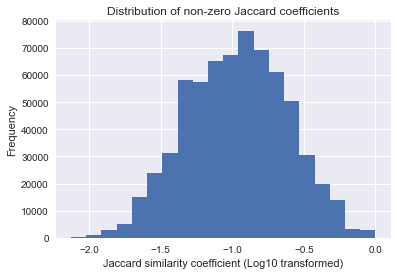